In [1]:
import numpy as np
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, CenteredNorm
import networkx as nx
import EoN
import igraph as ig
from PIL import Image

fear_threshold = 0.5

## Functions

In [35]:
# draw func

def draw_function(G):
    # Color by disease state
    disease_color_map = {'S': 'blue','Sf':'blue', 'E': 'orange', 'I': 'red', 'R': 'green'}
    node_colors = [disease_color_map[G.nodes[node]['disease_state']] for node in G.nodes()]
    
    # Shape by age class
    age_shape_map = {'A': 'o', 'E': 's', 'Y': '^'}  # o=circle, s=square, ^=triangle
    
    pos = nx.arf_layout(G)
    
    # Draw nodes by age class (different shapes)
    for age_class, shape in age_shape_map.items():
        # Get nodes with this age class
        nodes_in_class = [node for node in G.nodes() if G.nodes[node]['age_class'] == age_class]
        # Get their colors based on disease state
        colors_in_class = [disease_color_map[G.nodes[node]['disease_state']] for node in nodes_in_class]
        # get shade based on fear
        shade_in_fear = [0.4 if G.nodes[node]['fear'] > fear_threshold
                         else 1 for node in nodes_in_class]
        # Get their positions
        pos_in_class = {node: pos[node] for node in nodes_in_class}
        
        # Draw this subset
        nx.draw_networkx_nodes(G, pos=pos_in_class, nodelist=nodes_in_class,
                               node_color=colors_in_class, node_size=30, 
                               node_shape=shape, alpha=shade_in_fear)
    
    # Draw edges once
    nx.draw_networkx_edges(G, pos=pos, width=0.1, alpha=0.3)
    
    # Optional: add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='S'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='E'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='I'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='R'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Adult'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Elderly'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=8, label='Young'),
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.axis('off')
    plt.show()

# function that counts how many nodes for each class
def node_counter(G):
    nodes_counter = {
        'A':0,
        'E':0,
        'Y':0
    }
    for i in range (len(G.nodes)):
        node = G.nodes[i]
        nodes_counter[node['age_class']]+=1
    return nodes_counter

# funct to save plot to
def save_plot(G,time,filepath,pos):
    # Color by disease state
    disease_color_map = {'S': 'blue','Sf':'blue', 'E': 'orange', 'I': 'red', 'R': 'green'}
    node_colors = [disease_color_map[G.nodes[node]['disease_state']] for node in G.nodes()]
    
    # Shape by age class
    age_shape_map = {'A': 'o', 'E': 's', 'Y': '^'}  # o=circle, s=square, ^=triangle
    
    
    
    # Draw nodes by age class (different shapes)
    for age_class, shape in age_shape_map.items():
        # Get nodes with this age class
        nodes_in_class = [node for node in G.nodes() if G.nodes[node]['age_class'] == age_class]
        # Get their colors based on disease state
        colors_in_class = [disease_color_map[G.nodes[node]['disease_state']] for node in nodes_in_class]
        # Get their positions
        pos_in_class = {node: pos[node] for node in nodes_in_class}
        # get shade based on fear
        shade_in_fear = [0.4 if G.nodes[node]['fear'] > fear_threshold
                         else 1 for node in nodes_in_class]
        
        # Draw this subset
        nx.draw_networkx_nodes(G, pos=pos_in_class, nodelist=nodes_in_class,
                               node_color=colors_in_class, node_size=30, 
                               node_shape=shape, alpha=shade_in_fear)
    
    # Draw edges once
    nx.draw_networkx_edges(G, pos=pos, width=0.1, alpha=0.3)
    
    # Optional: add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='S'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='E'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='I'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='R'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Adult'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Elderly'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=8, label='Young'),
    ]
    #plt.legend(handles=legend_elements, loc='best')
    plt.title(f'Time-Step = {time}')
    plt.axis('off')
    plt.savefig(filepath)
    plt.close()

## Contact data

/tmp/ipykernel_2641/280160516.py:7: DtypeWarning: Columns (6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  contacts = pd.read_csv(os.path.join(data_path, '2008_Mossong_POLYMOD_contact_common.csv'))


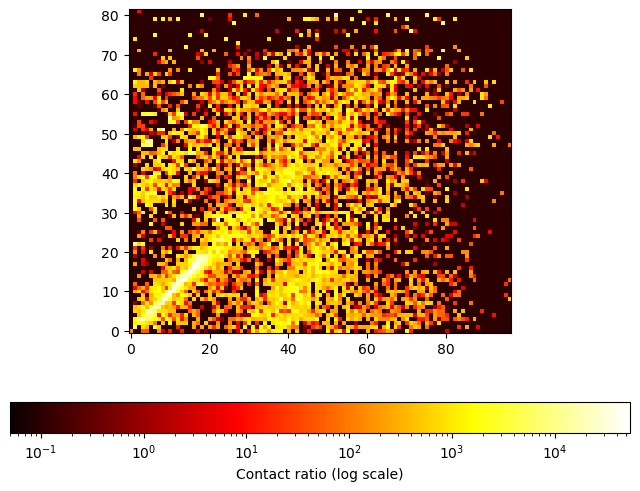

cont_cat,A,E,Y
part_cat,,,
A,0.528740,0.090234,0.381027
E,0.405755,0.404170,0.190074
Y,0.206117,0.022866,0.771018


In [3]:
# import of contact data
data_path = kagglehub.dataset_download("thedevastator/polymod-social-contacts-data")
files = os.listdir(data_path)
#print(f"Available files: {files}")

participants = pd.read_csv(os.path.join(data_path, "2008_Mossong_POLYMOD_participant_common.csv"))
contacts = pd.read_csv(os.path.join(data_path, '2008_Mossong_POLYMOD_contact_common.csv'))
nationalities = pd.read_csv(os.path.join(data_path, '2008_Mossong_POLYMOD_participant_extra.csv'))

# merge the dataframes to get desired data
data = pd.merge(participants,contacts, how = 'inner')[['part_id','part_age','cnt_age_exact','frequency_multi','duration_multi']]
data = pd.merge(data, nationalities, how = 'inner')[['part_id','part_age','cnt_age_exact','frequency_multi','duration_multi','participant_nationality']]
#print(f"Data has {np.shape(data)[0]} entries")
# drop NaN
data = data.dropna()
#print(f"Data has {np.shape(data)[0]} entries after dropping NA")

# select only italians
data = data[data['participant_nationality'] == 'IT']
#print(f"Data has {np.shape(data)[0]} entries after selecting only IT")

# define categories
data['part_cat'] = ['Y' if x <= 16.5 else(
                    'A' if x<= 65.5
                    else 'E') for x in data['part_age']]
data['cont_cat'] = ['Y' if x <= 18.5 else(
                    'A' if x<= 65.5
                    else 'E') for x in data['cnt_age_exact']]

# we shall now consider the columns frequency and duration
# duration categories: (1,2,3,4,5) are (less 5 min, 5 to 15 min, 15 min to 1h, 1-4 h, more than 4h)
# frequency categories: (1,2,3,4,5) are (daily, 1/2 times a week, 1/2 times a month, less than once a month, first time)
# we want the total time of the contacts. To achieve this we fix a time amount to compute, which is the number of minutes of contact in a full month
# we will substitue the rescaling factors in duration and frequency
data['frequency_multi'] = [30 if x == 1.0 else(
                            8 if x == 2.0 else(
                            1.5 if x == 3.0 else(
                            0.5 if x == 4.0 else(
                            1    
                            ))))for x in data['frequency_multi']]
data['duration_multi'] = [2.5 if x == 1.0 else(
                            10 if x == 2.0 else(
                            37.5 if x == 3.0 else(
                            120 if x == 4.0 else(
                            240    
                            ))))for x in data['duration_multi']]

# now compute the time (in minutes) in a month for the given contact
data['time'] = data['frequency_multi'] * data['duration_multi']

#plt.hist(data['time'])
#plt.show()

# Count contact time by exact age
contacts = data.groupby(['part_age','cnt_age_exact'], as_index=False)['time'].sum()
contacts_countings = data.groupby(['part_age','cnt_age_exact'], as_index=False)['time'].count()
contacts_matrix = contacts.pivot(index='part_age', columns='cnt_age_exact', values='time')
contacts_countings_matrix = contacts_countings.pivot(index = 'part_age', columns = 'cnt_age_exact', values = 'time')

# Count of participants by EXACT AGE (not categories!)
participant_counts = data.groupby('part_age')['part_id'].nunique()

#print("Contacts \n", contacts_matrix, "\n")
#print("Participant counts \n", participant_counts, "\n")

# Normalize
norm_contacts_matrix = contacts_matrix.div(participant_counts, axis=0)
#print("Normalized contact matrix:\n", norm_contacts_matrix, "\n")

# put zeros in places of NaN
norm_contacts_matrix[norm_contacts_matrix.isna()] = 0.1 # the log handles 0 poorly

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(norm_contacts_matrix, cmap='hot', norm=LogNorm())
plt.colorbar(im, ax=ax, label="Contact ratio (log scale)", orientation="horizontal")
ax.invert_yaxis()
plt.show()

# Count contact time by exact age
contacts = data.groupby(['part_cat','cont_cat'], as_index=False)['time'].sum()
contacts_matrix = contacts.pivot(index='part_cat', columns='cont_cat', values='time')

# Count of participants by EXACT AGE (not categories!)
participant_counts = data.groupby('part_cat')['part_id'].nunique()

#print("Contacts \n", contacts_matrix, "\n")
#print("Participant counts \n", participant_counts, "\n")

# Normalize
norm_contacts_matrix = contacts_matrix.div(participant_counts, axis=0)
#print("Normalized contact matrix:\n", norm_contacts_matrix, "\n")

# symmetrize the matrix and normalize rows to 1
norm_contacts_matrix = (norm_contacts_matrix + norm_contacts_matrix.T)/2
norm_contacts_matrix = norm_contacts_matrix.div(norm_contacts_matrix.sum(axis = 1), axis = 0)

norm_contacts_matrix

## Age data

In [4]:
# retrieve the data
pop_data = pd.read_csv("Resident population.csv")
total_IT_pop = pop_data['Total'].iloc[-1]
print(f"Total Italy population: {total_IT_pop} individuals")

# handle the last 2 lines 
pop_data.loc[100,'Age'] = 100
pop_data = pop_data.loc[:100,:]
pop_data_table = np.array(pop_data, dtype = float)
Y_pop = np.sum(pop_data_table[0:19,3])
A_pop = np.sum(pop_data_table[19:66,3])
E_pop = np.sum(pop_data_table[66:,3])
print(f"Total Y population: {Y_pop}, corresponding to {Y_pop/total_IT_pop*100}%")
print(f"Total A population: {A_pop}, corresponding to {A_pop/total_IT_pop*100}%")
print(f"Total E population: {E_pop}, corresponding to {E_pop/total_IT_pop*100}%")

Total Italy population: 58943464 individuals
Total Y population: 9356661.0, corresponding to 15.873958476549666%
Total A population: 35807880.0, corresponding to 60.74953450309605%
Total E population: 13778923.0, corresponding to 23.376507020354286%


## Network building

In [5]:
# initial populations of network in order A, E, Y 
N_tot = 100 # total
# N is list containing pop of A,E,Y initially
N = [int(A_pop/total_IT_pop*N_tot),int(E_pop/total_IT_pop*N_tot)]
N.append(N_tot-N[0]-N[1])
N


[60, 23, 17]

Removed 3713 edges
Edges remaining: 1237/4950


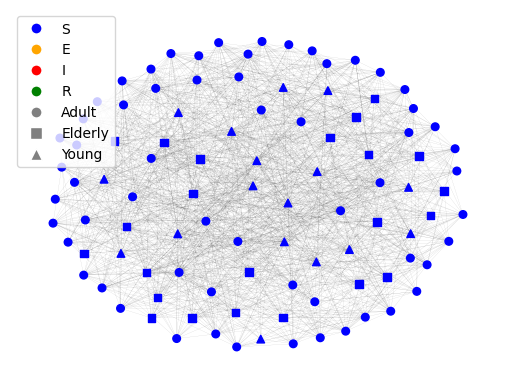

In [6]:
# creating nodes

# initial fear data distribution
fear_mu = [0.1,0.3,0.2]
fear_sigma = [0.03,0.07,0.03]

G = nx.Graph()
for i in range(N_tot):
    if (i < N[0]):
        age_class = 'A'
        fear = np.random.normal(fear_mu[0],fear_sigma[0])
    elif(i< N[1]+N[0]):
        age_class = 'E'
        fear = np.random.normal(fear_mu[1],fear_sigma[1])
    else:
        age_class = 'Y'       
        fear = np.random.normal(fear_mu[2],fear_sigma[2])
    # consistency check
    fear = min(fear,1)
    fear = max(fear,0)
    
    G.add_node(i, age_class = age_class, disease_state = 'S', fear = fear)

    
color_map = {'A': 'red', 'E': 'green', 'Y': 'yellow'}
node_colors = [color_map[G.nodes[node]['age_class']] for node in G.nodes()]

pos = nx.spring_layout(G,seed = 0)

# the initial setup is a FULLY CONNECTED
edges = []
for i in range(len(G.nodes)):
    for j in range(len(G.nodes)):
        if i!=j:
            edges.append((i,j))
G.add_edges_from(edges)

# Remove randomly some edges to make it realistic
total_edges = G.number_of_edges()
target_edges = int(total_edges * 0.25)  # Keep 25% of edges
edges_to_remove = total_edges - target_edges

# Get list of all edges and randomly sample which ones to remove
all_edges = list(G.edges())
edges_removed = np.random.choice(len(all_edges), size=edges_to_remove, replace=False)

for idx in edges_removed:
    u, v = all_edges[idx]
    G.remove_edge(u, v)

print(f"Removed {edges_to_remove} edges")
print(f"Edges remaining: {G.number_of_edges()}/{total_edges}")
draw_function(G)

In [7]:
# prob dict 
# average links to sample from by class
avg_links = {
    'A': 12,
    'E': 4,
    'Y': 20
}
# std for such average (sampling)
std_links = {
    'A': 3,
    'E': 1,
    'Y': 3
}

ages=np.array(['A','E','Y'])

# now we go with Barabasi Albert
final_size = 300  # Define the final network size

for i in range(N_tot, final_size):
    # Randomly assign age class to new node based on population distribution
    r = np.random.uniform(0,1)
    if r < N[0]/N_tot:
        age_class = 'A'
        fear = np.random.normal(fear_mu[0],fear_sigma[0])
    elif r < (N[0]+N[1])/N_tot:
        age_class = 'E'
        fear = np.random.normal(fear_mu[1],fear_sigma[1])
    else:
        age_class = 'Y'
        fear = np.random.normal(fear_mu[2],fear_sigma[2])
    
    # Add the new node with its age class
    G.add_node(i, age_class=age_class, disease_state = 'S', fear = fear)
    
    # Sample number of links from normal distribution based on age class
    n_links = max(1, int(np.random.normal(avg_links[age_class], std_links[age_class])))

    
    link=0
    connected_nodes=[]
    if age_class=='A':
        idx=0
    elif age_class=='E':
        idx=1
    else:
        idx=2
        
    while link < n_links:
        # select an age group based on contact probabilities
        target_age_probs = norm_contacts_matrix.iloc[idx]
        target_age = np.random.choice(ages, p=target_age_probs)
        
        # Get all nodes of the target age
        target_nodes = [node for node in G.nodes if G.nodes[node]['age_class'] == target_age]

        # degree of each potential target node for linking probability
        K = [G.degree(node) for node in target_nodes]
        K = np.array(K) # transform into numpy array
        total_degree = sum(K)

        link_prob = K/total_degree  ###linking probability for each target node

        while True:  ##check to see if I already connected 
            chosen_node = np.random.choice(target_nodes, p=link_prob)
            if chosen_node not in connected_nodes:
                linked_node = chosen_node
                connected_nodes.append(linked_node)
                break
        # Add edge
        G.add_edge(i, linked_node)
        link += 1

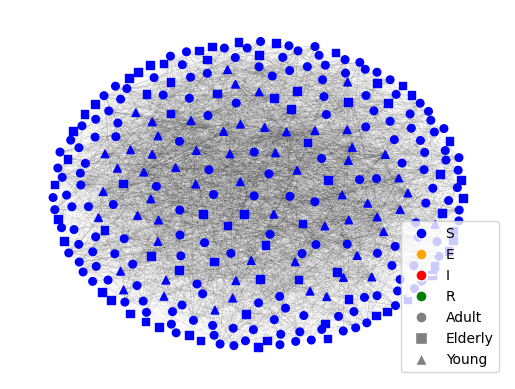

In [8]:
draw_function(G)

In [9]:
A = node_counter(G)['A']
E = node_counter(G)['E']
Y = node_counter(G)['Y']

tot = float(A)+float(E)+float(Y)
print(f"Fraction of A: {float(A)/tot}")
print(f"Fraction of E: {float(E)/tot}")
print(f"Fraction of Y: {float(Y)/tot}")

Fraction of A: 0.56
Fraction of E: 0.24
Fraction of Y: 0.2


# SEIR implementation


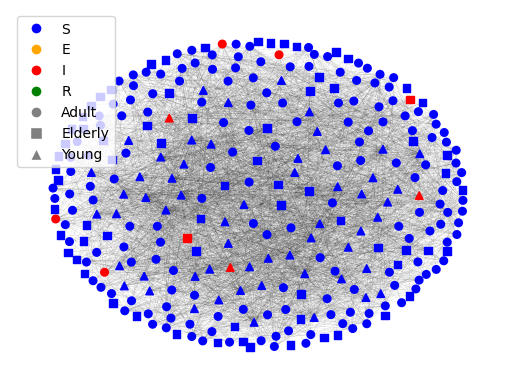

Number of initial Infected:  9


In [10]:
# some population will be infected at start
N = len(G.nodes)
frac = 0.03
I0 = int(N * frac)

# initial nodes infected are assigned here
#I_indices = np.int64(np.random.uniform(0,1,I0)*N)
I_indices = np.random.choice(range(N), size=I0, replace=False)
for idx in I_indices:
    G.nodes[idx]['disease_state'] = 'I'

draw_function(G)

# rates 
#beta = 0.1
#r_beta = 0.1
#gammaEI = 1./3
#gammaIR = 1./7
#mu_f = 0.25 # Sf + R -> S + R    and Sf + S -> 2S
#mu_fear_dist = 0.2         # mean of the gaussian to sample from in S-> Sf spontaneous trans 
sigma_fear_dist = 0.03     # std of the gaussian to sample from in S-> Sf spontaneous trans
#alpha = 0.8
delta = 1.



beta = {'A':0.12,
        'E':0.18,
        'Y':0.15} # transmission rate
r_beta = {'A':0.3,
        'E':0.1,
        'Y':0.25} # beta rescaling factor based on age class
gammaEI_resc = {'A':1.,
                'E':1.,
                'Y':0.8} # gammaEI rescaling factor based on age class
gammaIR_resc = {'A':1.,
                'E':1.5,
                'Y':0.75} # gammaIR rescaling factor based on age class
mu_f = {'A':0.3,
        'E':0.2,
        'Y':0.15} ### transition Sf+S->2S

mu_fear_dist = {'A':0.1,
                'E':0.2,
                'Y':0.2}  ##S-> Sf spontaneous trans 


alpha= {'A':0.7,
        'E':0.8,
        'Y':0.6}  # Sf + S -> 2 Sf 

gammaEI = {'A':0.2,
           'E':0.1,
           'Y':0.25} # recovery rate E to I

gammaIR = {'A':0.10,
           'E':0.05,
           'Y':0.15} # recovery rate I to R

print("Number of initial Infected: ", sum(G.nodes[n]['disease_state'] == 'I' for n in G.nodes))

# CUSTOM SEIR

In [11]:
status = {node: status for node, status in G.nodes(data='disease_state')}


In [12]:
def custom_SEIR_with_fear(G, beta, gammaEI, gammaIR, r_beta, mu_f, alpha,delta, mu_fear_dist, sigma_fear_dist,
                          gammaEI_resc, gammaIR_resc,
                          fear_threshold, 
                          tmax):

    # initial conditions
    status = {node: status for node, status in G.nodes(data='disease_state')}
    fear = {node: fear_val for node, fear_val in G.nodes(data='fear')}
    age_class = {node: age_class for node, age_class in G.nodes(data='age_class')}

    t = 0
    times = [0]
    statuses = [status.copy()]
    fears = [fear.copy()]
    
    while t < tmax:
        # calculate all possible events and rates
        events = []
        Ipop = list(status.values()).count('I')
        Ntot = len(G.nodes)
        # spontaneous transitions (E->I, I->R)
        for node in G.nodes():
            if status[node] == 'E':
                events.append(('EI', node, gammaEI[G.nodes[node]['age_class']] * gammaEI_resc[G.nodes[node]['age_class']]))
            elif status[node] == 'I':
                events.append(('IR', node, gammaIR[G.nodes[node]['age_class']] * gammaIR_resc[G.nodes[node]['age_class']]))
            # S -> Sf
            if status[node] == 'S':
                events.append(('fear',node,beta[G.nodes[node]['age_class']]*r_beta[G.nodes[node]['age_class']]*(1.-np.exp(-delta*float(Ipop)/float(Ntot))))) 
        
        # transmission events
        for node in G.nodes():
            # 1
            # S + I -> Sf + I
            if status[node] == 'I':
                for neighbor in G.neighbors(node):
                    if status[neighbor] in ['S']:
                        events.append(('fear_transmission_SI', (node, neighbor),min(1. - beta[G.nodes[neighbor]['age_class']]*2,0.1))) # 1-2beta prob of fear transmission event occurring
           
            # 2
            # Sf + I -> E + I
            if status[node] == 'I':
                for neighbor in G.neighbors(node):
                    if status[neighbor] in ['Sf']:
                        events.append(('transmission_SfE', (node, neighbor),beta[G.nodes[neighbor]['age_class']]*r_beta[G.nodes[neighbor]['age_class']])) # r_beta rescales beta (feared people stay at home)        

            # 3
            # S + I -> E + I 
            if status[node] == 'I':
                for neighbor in G.neighbors(node):
                    if status[neighbor] in ['S']:
                        events.append(('transmission_SE', (node, neighbor),beta[G.nodes[neighbor]['age_class']]))

            # 4
            # Sf + R -> S + R
            if status[node] in ['R','S']:
                for neighbor in G.neighbors(node):
                    if status[neighbor] in ['Sf']:
                        events.append(('fear_removal_SfR', (node, neighbor),mu_f[G.nodes[neighbor]['age_class']])) # mu_f prob of negazionism        

            # 5
            # Sf + S -> 2 Sf 
            if status[node] == 'Sf':
                for neighbor in G.neighbors(node):
                    if status[neighbor] in ['S']:
                        events.append(('fear_transmission_SS', (node, neighbor),alpha[G.nodes[neighbor]['age_class']]*beta[G.nodes[neighbor]['age_class']])) 
        
        if not events:
            break
        
        # Gillespie alg
        rates = np.array([e[2] for e in events])
        total_rate = rates.sum()
        
        # time to next event
        dt = np.random.exponential(1.0 / total_rate)
        t += dt
        
        # choose which event
        event_idx = np.random.choice(len(events), p=rates/total_rate)
        event_type, event_data, _ = events[event_idx]
        
        # execute event
        # spontaneous
        if event_type == 'EI':
            status[event_data] = 'I'
        elif event_type == 'IR':
            status[event_data] = 'R'
        elif event_type == 'fear':
            target = event_data # index of the node to put fear in
            fear[target] += np.random.normal(mu_fear_dist[G.nodes[target]['age_class']],sigma_fear_dist) 
            fear[target] = min(1,fear[target]) # safety check
            if fear[target] > fear_threshold:
                status[target] = 'Sf'

        # mediated
        # 1
        elif event_type == 'fear_transmission_SI':
            source, target = event_data  # source is I target is S, S will become Sf (maybe)
            
            # sample fear increment
            fear[target] += np.random.normal(mu_fear_dist[G.nodes[target]['age_class']],sigma_fear_dist) 
            fear[target] = min(1,fear[target]) # safety check
            if fear[target] > fear_threshold:
                status[target] = 'Sf'

        # 2
        elif event_type == 'transmission_SfE':
            source, target = event_data  # source is I target is Sf, Sf will become E 
            status[target] = 'E' # update target status

        # 3
        elif event_type == 'transmission_SE':
            source, target = event_data  # source is I target is S, S will become E 
            status[target] = 'E' # update target status

        # 4
        elif event_type == 'fear_removal_SfR':
            source, target = event_data  # source is R target is Sf, Sf will become S (maybe)
            
            # sample fear decrease
            fear[target] -= np.random.normal(mu_fear_dist[G.nodes[target]['age_class']],sigma_fear_dist) 
            fear[target] = max(0,fear[target]) # safety check
            if fear[target] <= fear_threshold:
                status[target] = 'S'

        # 5 
        elif event_type == 'fear_transmission_SS':
            source, target = event_data  # source is Sf target is S, S will become Sf (maybe)
            
            # sample fear increment
            fear[target] += np.random.normal(0,sigma_fear_dist*4.5) 
            fear[target] = max(min(1,fear[target]),0) # safety check
            if fear[target] > fear_threshold:
                status[target] = 'Sf'
            else:
                status[target] = 'S'
                
        times.append(t)
        statuses.append(status.copy())
        fears.append(fear.copy())
    
    return times, statuses,fears,age_class

In [13]:
tmax = 100
t, data,fears,age_classes = custom_SEIR_with_fear(G, beta, gammaEI, gammaIR, r_beta, mu_f, alpha,delta, mu_fear_dist, sigma_fear_dist,
                              gammaEI_resc, gammaIR_resc,
                              fear_threshold, 
                              tmax)


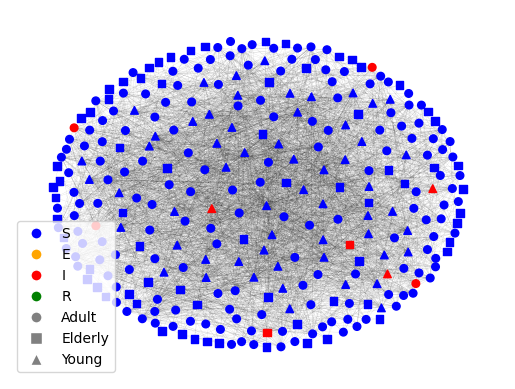

In [14]:
index = [0]
for idx in index:
    L = nx.Graph()
    L.add_nodes_from(data[idx])
    L.add_edges_from(G.edges)
    nx.set_node_attributes(L, values=data[idx], name='disease_state')
    nx.set_node_attributes(L, values=fears[idx], name='fear')
    nx.set_node_attributes(L, values=age_classes, name='age_class')
    draw_function(L)

In [15]:
I = []
R = []
S = []
E = []
for time in range(len(t)):
    I.append(len(np.where(np.array(list(data[time].values()))=='I')[0])) 
    R.append(len(np.where(np.array(list(data[time].values()))=='R')[0]))
    S.append(len(np.where(np.array(list(data[time].values()))=='S')[0]))
    E.append(len(np.where(np.array(list(data[time].values()))=='E')[0]))

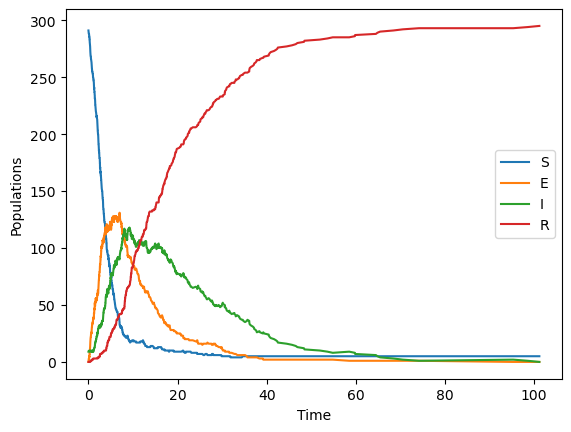

In [16]:
plt.plot(t,S,label='S')
plt.plot(t,E,label='E')
plt.plot(t,I,label='I')
plt.plot(t,R,label='R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Populations')
plt.show()


In [26]:
for i, time in enumerate(t):
    print(i,''time)

0 0
1 0.01882564304140188
2 0.021319998081271933
3 0.045332235532162694
4 0.06997412288359323
5 0.08133469657462498
6 0.0861870369552735
7 0.10861818793047195
8 0.1321908613021543
9 0.1393537979696318
10 0.16936161904152616
11 0.18340990472894705
12 0.19593520608936604
13 0.2416859285967252
14 0.2440359643463623
15 0.24439189017993596
16 0.27750831572007817
17 0.2795745211023269
18 0.2842988382338159
19 0.3098124698282254
20 0.3385594301454369
21 0.3554421752545977
22 0.37406829457924273
23 0.380188149353364
24 0.3857091520901661
25 0.3890437821063601
26 0.40049805584340525
27 0.4017622242946474
28 0.40283878085981584
29 0.4057855812192767
30 0.42143063278441945
31 0.4278591656414722
32 0.43858622234919875
33 0.45618692301858144
34 0.4734782310396703
35 0.47671735349588185
36 0.519374827278704
37 0.5448155710751145
38 0.5482537530119017
39 0.5611947903781278
40 0.5649256783308686
41 0.5825953403646374
42 0.6205907481625982
43 0.6418042182902699
44 0.6432665355130722
45 0.65316281351977

In [38]:
# times of snapshot

for i,time in enumerate(t):
    if i%25==0:
        L = nx.Graph()
        L.add_nodes_from(data[i])
        L.add_edges_from(G.edges)
        nx.set_node_attributes(L, values=data[i], name='disease_state')
        nx.set_node_attributes(L, values=fears[i], name='fear')
        nx.set_node_attributes(L, values=age_classes, name='age_class')
    
        # select pos once for all plots
        if i == 0:
            pos = nx.arf_layout(G)
        
        # make a folder
        os.makedirs('frames', exist_ok=True)
        filepath = f'frames/network_status_time_{i}.png'
        save_plot(L,i,filepath,pos)

In [39]:
# produce GIF
# make a folder
os.makedirs('gifs', exist_ok=True)
frames = []
for i,time in enumerate(t):
    if i%25==0:
        img = Image.open(f'frames/network_status_time_{i}.png')
        frames.append(img)
        
        frames[0].save(f'gifs/network_animation.gif', 
                       save_all=True, 
                       append_images=frames[1:], 
                       duration=900,  # milliseconds per frame
                       loop=0)
    
print("GIF saved as network_animation.gif")

GIF saved as network_animation.gif
